In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats, optimize
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os

In [4]:

# Japan earthquakes from kaggle
df = pd.read_csv("database.csv")

In [11]:
df = df.drop([3378,7512,20650]) #Drop error data

In [12]:
df.describe()

,Latitude,Longitude,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square
count,23409.000000,23409.000000,23409.000000,4460.000000,7096.000000,23409.000000,327.000000,2564.000000,7298.000000,1604.000000,1156.000000,17350.000000
mean,1.678763,39.636726,70.748526,4.991118,275.362176,5.882558,0.071820,48.944618,44.165158,3.992660,7.662759,1.022766
std,30.113379,125.514881,122.605748,4.873905,162.152976,0.423084,0.051466,62.943106,32.143388,5.377262,10.430396,0.188544
min,-77.080000,-179.997000,-1.100000,0.000000,0.000000,5.500000,0.000000,0.000000,0.000000,0.004505,0.085000,0.000000
25%,-18.652000,-76.352000,14.530000,1.800000,146.000000,5.600000,0.046000,10.000000,24.100000,0.968750,5.300000,0.900000
50%,-3.569000,103.981000,33.000000,3.500000,255.000000,5.700000,0.059000,28.000000,36.000000,2.319500,6.700000,1.000000
75%,26.188000,145.027000,54.000000,6.300000,384.000000,6.000000,0.075500,66.000000,54.000000,4.724500,8.100000,1.130000
max,86.005000,179.998000,700.000000,91.295000,934.000000,9.100000,0.410000,821.000000,360.000000,37.874000,99.000000,3.440000


In [31]:
# Conditional intensity λ with log-entries
def λ(param,Tmax,Mc,Ti,Mi,T):
    a,c,p,k,mu = np.exp(param)
    return mu+((T>Ti)*k*np.exp(a*(Mi - Mc))/((T>Ti)*(T - Ti) + c)**p).sum()

In [32]:
# Cumulative intensity Λ(t) = \int_0^t λ(s)ds
def Λ(param,Tmax,Mc,Ti,Mi,T):
    a,c,p,k,mu=np.exp(param)    
    if abs(p-1)<0.001:
        N = mu*T + ((T>=Ti)*k*np.exp(a*(Mi - Mc))* \
                    ( (np.log((T>=Ti)*(T - Ti)+ c)**1-np.log(c)**1) \
                     +(np.log((T>=Ti)*(T - Ti)+ c)**2-np.log(c)**2)*(1-p)**1/2 \
                     +(np.log((T>=Ti)*(T - Ti)+ c)**3-np.log(c)**3)*(1-p)**2/6 \
                   )).sum() #using Taylor series at p=1
    else:
        N = mu*T + ((T>=Ti)*k*np.exp(a*(Mi - Mc))*(((T>=Ti)*(T - Ti) + c)**(1-p)-c**(1-p))/(1-p)).sum()
    return N

In [64]:
def minusloglik(param,Tmax,Mc,Ti,Mi):
    a,c,p,k,mu=np.exp(param)
    if abs(p-1)<0.001:
        loglik = np.array([np.log(mu+((t>Ti)*k*np.exp(a*(Mi - Mc))/((t>Ti)*(t - Ti) + c)**p).sum()) for t in Ti]).sum() \
                   - mu*Tmax - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))* \
                   ( (np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**1-np.log(c)**1) \
                    +(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**2-np.log(c)**2)*(1-p)**1/2 \
                    +(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**3-np.log(c)**3)*(1-p)**2/6 \
                   )).sum()
    else:
        loglik = np.array([np.log(mu+((t>Ti)*k*np.exp(a*(Mi - Mc))/((t>Ti)*(t - Ti) + c)**p).sum()) for t in Ti]).sum() \
                   - mu*Tmax - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))*(((Tmax>=Ti)*(Tmax - Ti) + c)**(1-p)-c**(1-p))/(1-p)).sum()
    return -loglik

In [65]:
def gradminusloglik(param,Tmax,Mc,Ti,Mi):
    a,c,p,k,mu=np.exp(param)
    grad=np.zeros(5)
    
    #∂/∂xΣlogλ(t,x)
    for i, t in enumerate(Ti):
        ramda=mu+((t>Ti)*k*np.exp(a*(Mi - Mc))/((t>Ti)*(t - Ti) + c)**p).sum()
        grad[0]+=((t>Ti)*k*np.exp(a*(Mi - Mc))*(Mi - Mc)                      /((t>Ti)*(t - Ti) + c)**p    ).sum()/ramda
        grad[1]+=((t>Ti)*k*np.exp(a*(Mi - Mc))*(-p)                           /((t>Ti)*(t - Ti) + c)**(p+1)).sum()/ramda
        grad[2]+=((t>Ti)*k*np.exp(a*(Mi - Mc))*np.log(1/((t>Ti)*(t - Ti) + c))/((t>Ti)*(t - Ti) + c)**p    ).sum()/ramda
        grad[3]+=((t>Ti)*1*np.exp(a*(Mi - Mc))                                /((t>Ti)*(t - Ti) + c)**p    ).sum()/ramda
        grad[4]+= 1/ramda

    #∂/∂x∫λ(t,t)dt
    if abs(p-1)<0.001:
        grad[0]+= - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))*(Mi - Mc)* \
                       (    (np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**1-np.log(c)**1) \
                           +(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**2-np.log(c)**2)*(1-p)**1/2 \
                           +(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**3-np.log(c)**3)*(1-p)**2/6 \
                       )).sum() 
        grad[1]+= - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))*(((Tmax>=Ti)*(Tmax - Ti) + c)**(0-p)-c**(0-p))).sum()
        grad[2]+= - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))* \
                       (   -(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**2-np.log(c)**2)/2 \
                           -(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**3-np.log(c)**3)*(1-p)/3 \
                           -(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**4-np.log(c)**4)*(1-p)**2/8 \
                       )).sum()
        grad[3]+= - ((Tmax>=Ti)*np.exp(a*(Mi - Mc))* \
                       (    (np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**1-np.log(c)**1) \
                           +(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**2-np.log(c)**2)*(1-p)**1/2 \
                           +(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**3-np.log(c)**3)*(1-p)**2/6 \
                       )).sum()
        grad[4]+= - Tmax

    else:
        dp=0.001
        pp0=(((Tmax>=Ti)*(Tmax - Ti) + c)**(1-p+dp/2)-c**(1-p+dp/2))/(1-p+dp/2)
        pp1=(((Tmax>=Ti)*(Tmax - Ti) + c)**(1-p-dp/2)-c**(1-p-dp/2))/(1-p-dp/2)
        pp = (pp1-pp0)/dp
        
        grad[0]+= - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))*(Mi - Mc)*(((Tmax>=Ti)*(Tmax - Ti) + c)**(1-p)-c**(1-p))/(1-p)).sum()
        grad[1]+= - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))*1        *(((Tmax>=Ti)*(Tmax - Ti) + c)**(0-p)-c**(0-p)      )).sum()
        grad[2]+= - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))*pp                                                            ).sum()
        grad[3]+= - ((Tmax>=Ti)*1*np.exp(a*(Mi - Mc))*1        *(((Tmax>=Ti)*(Tmax - Ti) + c)**(1-p)-c**(1-p))/(1-p)).sum()
        grad[4]+= - Tmax

    return -grad*np.exp(param) #∂f(x)/∂(log(x))=∂f(x)/∂x*x

In [14]:

# Slice data
df_japan = df.query('25 < Latitude < 50 and 125 < Longitude < 150')
df_japan = df_japan.reset_index(drop=True)
df_japan["Date_Time"] = pd.to_datetime(df_japan["Date"]+" "+df_japan["Time"], format = "%m/%d/%Y %H:%M:%S")

In [15]:
# Prepare input data
Mag = df_japan["Magnitude"].values
T = Mag*0
for i,t in enumerate(df_japan["Date_Time"]):
    T[i] = (t-df_japan["Date_Time"][0]).total_seconds()/60/60/24

In [18]:
MagCut = 5.5 #cut off magnitude
Tmax = T.max()

In [19]:

# initial values
a,c,p,k,mu = 1.0, 0.1, 1.1, 0.1, 0.1
param_initial = np.array([a,c,p,k,mu])

In [21]:
# Fit
log_param_initial = np.log(param_initial) #log-param
args = (Tmax, MagCut,T, Mag)

In [147]:

param_fitted = optimize.fmin_bfgs( minusloglik, log_param_initial, fprime=gradminusloglik, args=(Tmax,MagCut,T,Mag),gtol=0.0001)

         Current function value: 4728.336468
         Iterations: 24
         Function evaluations: 96
         Gradient evaluations: 85


In [148]:
param_fitted = np.exp(log_param_fitted)
print("a,c,p,k,mu=",param_fitted)

a,c,p,k,mu= [2.02936102 0.01781398 1.09279287 0.009344   0.05250797]


In [149]:
# Conditional intensity λ with log-entries
def λ(param,Tmax,Mc,Ti,Mi,T):
    a,c,p,k,mu = np.exp(param)
    return mu+((T>Ti)*k*np.exp(a*(Mi - Mc))/((T>Ti)*(T - Ti) + c)**p).sum()

In [150]:
# P[ j-thearthquakes is an offspring of of i-th earthquake | H_{t_j} ]
def P(param,Tmax,Mc,Ti,Mi):
    a,c,p,k,mu = np.exp(param)
    n = len(T)
    P = np.zeros((n,n))
    for i in range(0,n-1):
        for j in range(0,n-1):
            P[j,i] =  (Ti[j] > Ti[i])*k*np.exp(a*(Mi[i] - Mc))/((Ti[j]>Ti[i])*(Ti[j] - Ti[i]) + c)**p / λ(param,Tmax,Mc,Ti,Mi,Ti[j])
    return P

In [151]:
P_mat = P(param_fitted,Tmax,MagCut,T,Mag)

In [152]:
P_mat

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.86836576e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.65637547e-05, 2.65706437e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.88082193e-16, 1.00849864e-13, 1.01053271e-13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.27366487e-15, 1.70953007e-12, 1.71297175e-12, ...,
        5.09674773e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [153]:
P_vec = np.array([ P_mat[i].sum() for i in range(0,len(P_mat[1]))] )

In [154]:
1 - P_vec

array([1.00000000e+00, 9.99813163e-01, 7.34247000e-01, ...,
       6.33718441e-04, 1.08011931e-02, 1.00000000e+00])

In [232]:
T_declust = T[np.random.rand(len(P_vec)) < 1 - P_vec]

Theorem 1 (Cinlar, 1975). Let $\Lambda(t)$, $t\geq0$ be a positive-valued, continuous, nondecreasing function.   Then the random variables $\left\{T_i\right\}_{i=1}^\infty$ are event times corresponding to a nonhomogeneous Poisson process with expectation function $\Lambda(t)$ if and only if $\left\{\Lambda(T_i)\right\}_{i=1}^\infty$ are the event times corresponding to a homogeneous Poisson process with rate one.

In [234]:
T_unitpoi_declust = [ Λ(param_fitted,Tmax,MagCut,T,Mag,T_declust[i]) for i in range(0,len(T_declust)-1) ]

In [235]:
inter_T_unitpoi_declust = np.array([ T_unitpoi_declust[i+1] - T_unitpoi_declust[i] for i in range(0,len(T_unitpoi_declust)-1) ])

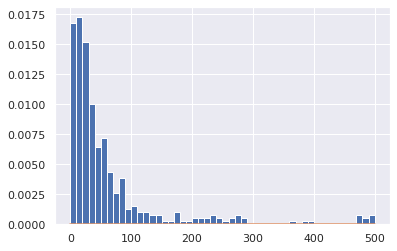

In [236]:
plt.hist( inter_T_unitpoi_declust,range=(0,500),bins=50,density=True)
plt.plot( np.linspace(0,500,100), [np.exp(-i/np.mean(inter_T_unitpoi_declust))/np.mean(inter_T_unitpoi_declust) for i in np.linspace(0,500,100) ] )
plt.show()

In [177]:
from scipy import stats

In [198]:
stats.kstest(inter_T_unitpoi_declust,'expon')

KstestResult(statistic=0.9426193472299227, pvalue=0.0)

In [211]:
stats.kstest(inter_T_unitpoi_declust,stats.expon(scale=1/np.mean(inter_T_unitpoi_declust)).cdf)

KstestResult(statistic=1.0, pvalue=0.0)

In [197]:
np.sum(inter_T_unitpoi_declust <= 500)

404

In [212]:
stats.kstest( np.sort(inter_T_unitpoi_declust )[0:403],stats.expon(scale=1/np.mean(inter_T_unitpoi_declust[0:403])).cdf)

KstestResult(statistic=0.9999999739041194, pvalue=0.0)

In [200]:
np.sum(inter_T_unitpoi_declust <= 300)

393

In [213]:
stats.kstest( np.sort(inter_T_unitpoi_declust )[0:392],stats.expon(scale=1/np.mean(inter_T_unitpoi_declust[0:392])).cdf)

KstestResult(statistic=0.999999576528685, pvalue=0.0)

In [214]:
np.sum(inter_T_unitpoi_declust <= 200)

369

In [215]:
stats.kstest( np.sort(inter_T_unitpoi_declust )[0:368],stats.expon(scale=1/np.mean(inter_T_unitpoi_declust[0:368])).cdf)

KstestResult(statistic=0.9999856821643183, pvalue=0.0)

In [216]:
np.sum(inter_T_unitpoi_declust <= 100)

340

In [217]:
stats.kstest( np.sort(inter_T_unitpoi_declust )[0:339],stats.expon(scale=1/np.mean(inter_T_unitpoi_declust[0:339])).cdf)

KstestResult(statistic=0.9998549933669963, pvalue=0.0)

In [250]:
def b(v):
    return len(v)/np.log(v/min(v)).sum()

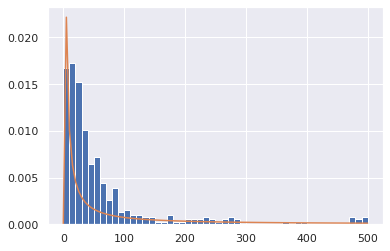

In [255]:
plt.hist( inter_T_unitpoi_declust,range=(0,500),bins=50,density=True)
plt.plot( np.linspace(0,500,100), [stats.pareto.pdf(i,b(inter_T_unitpoi_declust)) for i in np.linspace(0,500,100) ] )
plt.show()

In [256]:
stats.kstest(inter_T_unitpoi_declust,stats.pareto(b=b(inter_T_unitpoi_declust)).cdf)

KstestResult(statistic=0.2272681180616627, pvalue=1.5256810033338736e-22)

In [257]:
stats.kstest(inter_T_unitpoi_declust[0:403],stats.pareto(b=b(inter_T_unitpoi_declust[0:403])).cdf)

KstestResult(statistic=0.2205838097595343, pvalue=3.0055581984155394e-21)

In [259]:
stats.kstest(inter_T_unitpoi_declust[0:392],stats.pareto(b=b(inter_T_unitpoi_declust[0:392])).cdf)

KstestResult(statistic=0.23862254424761042, pvalue=3.99425594706895e-20)

In [260]:
stats.kstest(inter_T_unitpoi_declust[0:368],stats.pareto(b=b(inter_T_unitpoi_declust[0:368])).cdf)

KstestResult(statistic=0.23982075244968304, pvalue=4.1262029939600523e-19)

In [261]:
stats.kstest(inter_T_unitpoi_declust[0:339],stats.pareto(b=b(inter_T_unitpoi_declust[0:339])).cdf)

KstestResult(statistic=0.243257550345932, pvalue=3.8064034931831985e-18)